# Deep Learning (Foundations): Course Project

**University:** NOVA Information Management School<<br/>
**Program:** Master’s Degree Program in Data Science and Advanced Analytics<br/>
**Academic Year:** 2022/2023

```
============== Students: ==============
Iryna Savchuk (m20211310@novaims.unl.pt)
Cátia Sofia Pereira Parrinha (m20201320@novaims.unl.pt)
Giulia Bovenga (m20221637@novaims.unl.pt)
Hubert Oberhauser (m20220628@novaims.unl.pt)
Leo Allgaier (m20220635@novaims.unl.pt)
=======================================
```
**Data Source**
*   Clean data to perform model training can be downloaded from here: [datasets.zip](https://drive.google.com/file/d/1xMF-lupg9UX-UZUD6NlC2h-Ao08gQ6f3/view?usp=sharing)

* Original data can be downloaded from here: 
  * [train](https://storage.googleapis.com/ibeans/train.zip)
  * [validation](https://storage.googleapis.com/ibeans/validation.zip)
  * [test](https://storage.googleapis.com/ibeans/test.zip)

* Original data description: https://github.com/AI-Lab-Makerere/ibean/
------------------------------
**Summary**

The current notebook contains the first steps of the Deep Learning course project: problem definition, download and extraction of the original data, and further data exploration.  

## Project Details

### Data Description
Images of beans have been taken in the field by the Makerere AI research lab representatives with the help of smartphone cameras. The data was then annotated by experts from the National Crops Resources Research Institute (NaCRRI) in Uganda.

The data consists of 3 classes of images: 2 disease classes and the healthy class. Diseases depicted include Angular Leaf Spot and Bean Rust. 

### Problem Definition
Having images of 3 classes of bean plants (the class of healthy plants, and two classes of disease plants including Angular Leaf Spot desease and Bean Rust disease), build a robust Deep Learning model that will be able to distinguish between these 3 classes with high accuracy.

## Dataset Download and Extraction

In [1]:
# Importing packages
import requests 
import os
import zipfile

import random 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
import cv2

In [2]:
train_URL = "https://storage.googleapis.com/ibeans/train.zip"
validation_URL = "https://storage.googleapis.com/ibeans/validation.zip"
test_URL = "https://storage.googleapis.com/ibeans/test.zip"

data_folder = "datasets/" 

### Datasets Download and Extraction

In [3]:
def download_data(url_to_zip, destination_folder = data_folder):
  # Downloading the file by sending the request to the URL
  req = requests.get(url_to_zip)
  # Splitting URL to get the file name
  filename = url_to_zip.split('/')[-1]
  
  # Check if 'destination_folder' exists 
  if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)  # create a new directory of doesn't exist

  # Writing file to 'destination_folder'
  with open(destination_folder + filename,'wb') as output_file:
    output_file.write(req.content)

  # Extracting files from zip archive
  zip_ = zipfile.ZipFile(destination_folder + filename)
  zip_.extractall(destination_folder)
  zip_.close()

  # Removing zip archive after it is extracted
  os.remove(os.path.join(destination_folder, filename))

In [4]:
for dataset in [train_URL, validation_URL, test_URL]:
  download_data(dataset)
  print('Download and extraction finished for ', dataset)

Download and extraction finished for  https://storage.googleapis.com/ibeans/train.zip
Download and extraction finished for  https://storage.googleapis.com/ibeans/validation.zip
Download and extraction finished for  https://storage.googleapis.com/ibeans/test.zip


In [5]:
training_folder, validation_folder, testing_folder = "train/", "validation/", "test/"
classes = ["healthy", "angular_leaf_spot", "bean_rust"]

### Showing Data Samples

In [6]:
def show_sample_images(folder, class_name):
    # Build a connection string
    full_path = folder + class_name + "/"
    # Get a set of random images
    images = random.sample(os.listdir(full_path), 4, )
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        img = mpimg.imread(full_path + img)
        ax = plt.subplot(2, 2,  i + 1)
        plt.imshow(img)
        plt.title("{} image of class \"{}\"".format(img.shape, class_name))
        plt.axis("off")

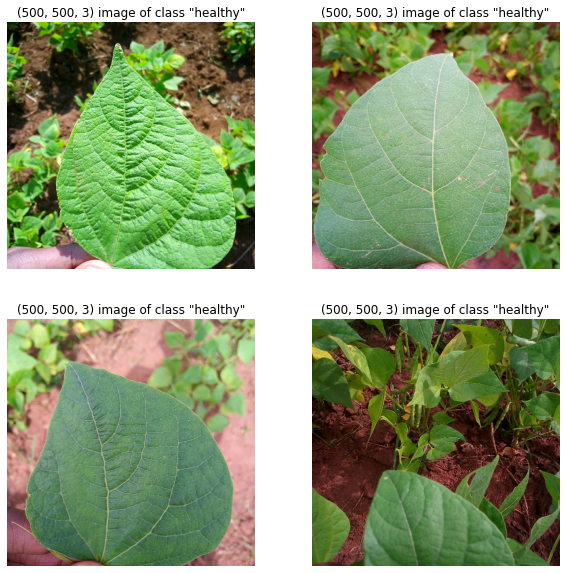

In [7]:
show_sample_images(data_folder + training_folder, "healthy")

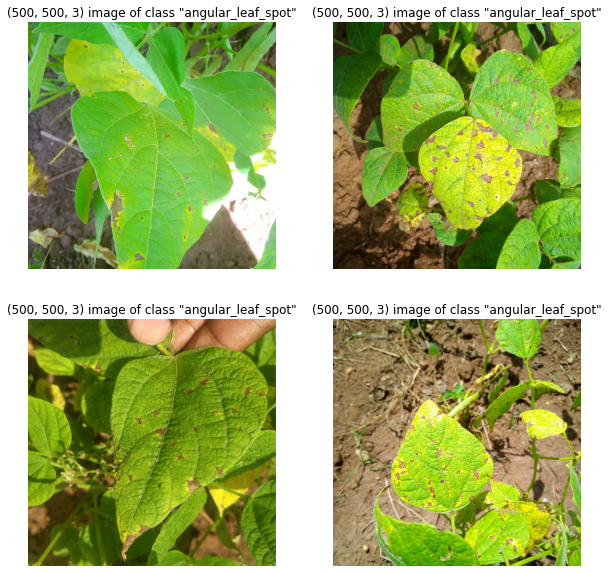

In [8]:
show_sample_images(data_folder + training_folder, "angular_leaf_spot")

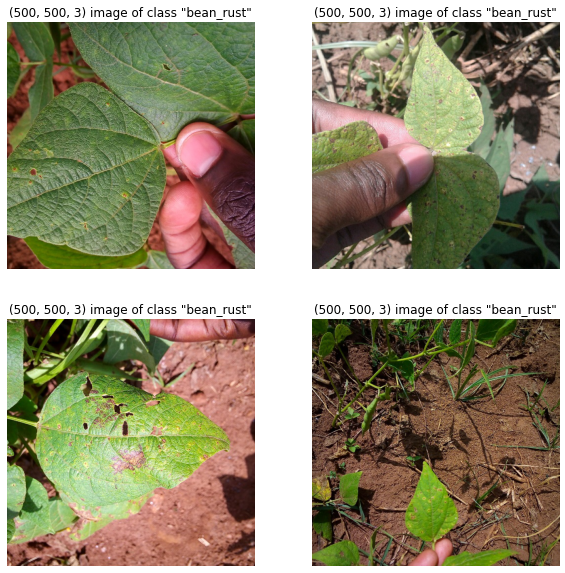

In [9]:
show_sample_images(data_folder + training_folder, "bean_rust")

## 2. Dataset Quality Check

In [10]:
# Inspecting initial classes balance:
for split in [training_folder, testing_folder, validation_folder]:
  print(split)
  for c in classes:
    n_c = len(os.listdir(data_folder + split + f"/{c}"))
    print(f"Nº of instances of class '{c}': {n_c}")

train/
Nº of instances of class 'healthy': 342
Nº of instances of class 'angular_leaf_spot': 345
Nº of instances of class 'bean_rust': 348
test/
Nº of instances of class 'healthy': 42
Nº of instances of class 'angular_leaf_spot': 43
Nº of instances of class 'bean_rust': 43
validation/
Nº of instances of class 'healthy': 44
Nº of instances of class 'angular_leaf_spot': 44
Nº of instances of class 'bean_rust': 45


### Checking files extensions

In [11]:
def count_extensions(directory_path):
  count_dict = {}
  file_names = os.listdir(directory_path)
  for file_name in file_names:
    ext = file_name.split(".")[-1]
    if ext in count_dict:
      count_dict[ext] += 1
    else: 
      count_dict[ext] = 1
  return count_dict

In [12]:
for split in [training_folder, testing_folder, validation_folder]:
  for c in classes:
    path = os.path.join(data_folder, split, c)
    print(path, ' : ', count_extensions(path))

datasets/train/healthy  :  {'jpg': 341, '120tore': 1}
datasets/train/angular_leaf_spot  :  {'jpg': 345}
datasets/train/bean_rust  :  {'jpg': 348}
datasets/test/healthy  :  {'jpg': 42}
datasets/test/angular_leaf_spot  :  {'jpg': 43}
datasets/test/bean_rust  :  {'jpg': 43}
datasets/validation/healthy  :  {'jpg': 44}
datasets/validation/angular_leaf_spot  :  {'jpg': 44}
datasets/validation/bean_rust  :  {'jpg': 45}


As can be seen, there is one file with unknown extension in our training dataset. Since this file seems to be corrupted (the image cannot be opened and viewed), it has been decided to remove this file from the dataset, to not impact the training process.  

In [13]:
# Removing corrupted file
for item in os.listdir("datasets/train/healthy"):
    if item.endswith(".120tore"):
        os.remove(os.path.join("datasets/train/healthy", item))

# Checking the updated extension counts:
for split in [training_folder, testing_folder, validation_folder]:
  for c in classes:
    path = os.path.join(data_folder, split, c)
    print(path, ' : ', count_extensions(path))

datasets/train/healthy  :  {'jpg': 341}
datasets/train/angular_leaf_spot  :  {'jpg': 345}
datasets/train/bean_rust  :  {'jpg': 348}
datasets/test/healthy  :  {'jpg': 42}
datasets/test/angular_leaf_spot  :  {'jpg': 43}
datasets/test/bean_rust  :  {'jpg': 43}
datasets/validation/healthy  :  {'jpg': 44}
datasets/validation/angular_leaf_spot  :  {'jpg': 44}
datasets/validation/bean_rust  :  {'jpg': 45}


### Class Balance (after corrupted file removal)

In [14]:
# Inspecting updated classes balance:
for split in [training_folder, validation_folder, testing_folder]:
  print(split)
  for c in classes:
    n_c = len(os.listdir(data_folder + split + f"/{c}"))
    print(f"Nº of instances of class '{c}': {n_c}")

train/
Nº of instances of class 'healthy': 341
Nº of instances of class 'angular_leaf_spot': 345
Nº of instances of class 'bean_rust': 348
validation/
Nº of instances of class 'healthy': 44
Nº of instances of class 'angular_leaf_spot': 44
Nº of instances of class 'bean_rust': 45
test/
Nº of instances of class 'healthy': 42
Nº of instances of class 'angular_leaf_spot': 43
Nº of instances of class 'bean_rust': 43


### Images Shape Exploration

In [15]:
for split in [training_folder, validation_folder, testing_folder]:
  image_shapes = {} # Counting dictionary for this split(folder)
  for c in classes:
    image_names_lst = os.listdir(data_folder + split + f"/{c}")
    for image_name in image_names_lst:
      image_path = os.path.join(data_folder, split, c, image_name)
      img = Image.open(image_path)

      # Obtain shape of a particular image 
      shape = (img.width, img.height, img.mode) 

      # Update Counting dictionary
      if shape in image_shapes:
        image_shapes[shape] += 1
      else: 
        image_shapes[shape] = 1  

  print(split, image_shapes)

train/ {(500, 500, 'RGB'): 1034}
validation/ {(500, 500, 'RGB'): 133}
test/ {(500, 500, 'RGB'): 128}


### Image Blurriness Exploration

A blurred image, if present in the dataset, can impact exploratory analysis and the training process. Unless blurriness is a distinct feature of a class (which is not the case here), we would like to avoid having irrelevant noise in the data.

It is possible to check the level of image blurriness using Laplacian function from OpenCV library: the variance of the Laplacian returns a focus measure, basically a number.

In [16]:
def variance_of_laplacian(image):
  return cv2.Laplacian(image, cv2.CV_64F).var()

# Checking variance of Laplacian for a random picture
image_path = "/content/datasets/train/healthy/healthy_train.0.jpg"
image = cv2.imread(image_path)
variance_of_laplacian(image)

4925.676862722731

Minimum focus measure in the /datasets:  105.79400548897958    datasets/train/bean_rust/bean_rust_train.186.jpg


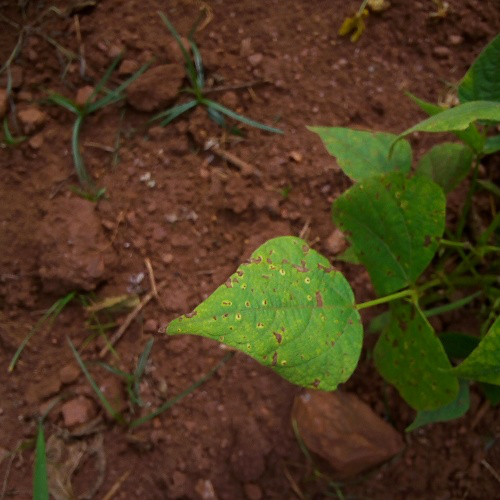


Maximum focus measure in the /datasets:  23077.581668407598    datasets/train/bean_rust/bean_rust_train.243.jpg


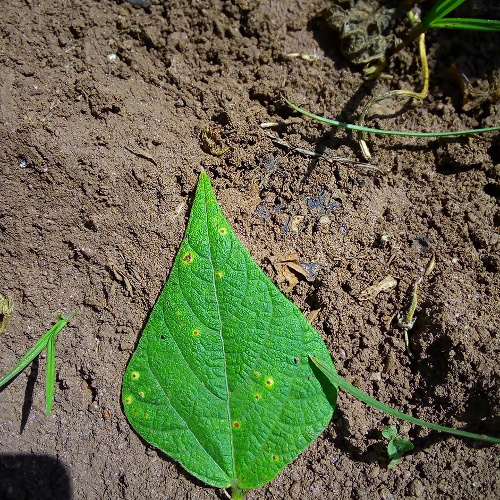

In [17]:
min_blurring = 1000000
max_blurring = 0
min_img = ""
max_img = ""
for split in [training_folder, validation_folder, testing_folder]:
  for c in classes:
    image_names_lst = os.listdir(data_folder + split + f"/{c}")
    for image_name in image_names_lst:
      image_path = os.path.join(data_folder, split, c, image_name)
      image = cv2.imread(image_path)
      var = variance_of_laplacian(image)
      if var > max_blurring:
        max_blurring = var
        max_img = image_path
      if var < min_blurring:
        min_blurring = var
        min_img = image_path

print("Minimum focus measure in the /datasets: ", min_blurring, "  ", min_img)
Image.open(min_img).show()  
print("\nMaximum focus measure in the /datasets: ", max_blurring, "  ", max_img)
Image.open(max_img).show()  

As can be seen, even the most "unfocused" picture in datasets at hand is rather clear, so we will not filter out any images based on blurriness.

## Outcome 

The original dataset of bean plants images is already split for us into three groups (train, validation, test). 

When one corrupted file is removed from the raw data, there are 1034 images for training, 133 for validation, 128 images for testing:

| Split            | Samples | 
| :---------------- | :------: | 
| train        |   1034   | 
| validation          |   133   |
| test   |  128   | 

All the files have 3 channels (RGB) and are of the same size (500x500 pixels). In addition, the labels are almost equally distributed between classes for the given splits:

|   | Train      | Validation    | Test  |
|:--|:----------|:-------------:| -----:|
|healthy         | 341 | 345 | 348 |
|angular_leaf_spot | 44  | 44  |   45|
|bean_rust      | 42  | 43  |   43|

We have also check if there are any completely blurred (unfocused) images in the dataset, and it turned out that even the most "unfocused" picture at hand is rather clear, so we will not filter out any images based on blurriness.